# Lesson 28: TensorFlow/Keras neural network demonstration - part 1

## Notebook set up
### Imports

In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, Model

tf.random.set_seed(315)

## 1. Data preparation

### 1.1. Load California housing data

In [2]:
housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
label = 'MedHouseVal'
features = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']

### 1.2. Train test split

In [5]:
training_df, testing_df = train_test_split(housing_df, random_state=42)

### 1.3. Standard scale

#### Features

In [6]:
feature_scaler = StandardScaler()
feature_scaler.fit(training_df[features])

training_df[features] = feature_scaler.transform(training_df[features])
testing_df[features] = feature_scaler.transform(testing_df[features])

#### Label

In [7]:
label_scaler = StandardScaler()
label_scaler.fit(training_df[label].to_frame())

training_df[label] = label_scaler.transform(training_df[label].to_frame())
testing_df[label] = label_scaler.transform(testing_df[label].to_frame())

### 1.4. Handle outliers

In [8]:
for feature in features:

    q1 = training_df[feature].quantile(0.25)
    q3 = training_df[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    training_df[feature] = training_df[feature].clip(lower=lower_bound, upper=upper_bound)
    testing_df[feature] = testing_df[feature].clip(lower=lower_bound, upper=upper_bound)

## 2. Linear regression baseline

### 2.1. Fit

In [9]:
linear_model = LinearRegression(n_jobs=-1)
fit_result = linear_model.fit(training_df[features], training_df[label])

### 2.2. Test set evaluation

In [10]:
linear_predictions = linear_model.predict(testing_df[features])
linear_rsquared = linear_model.score(testing_df[features], testing_df[label])
print(f'Linear regression R² on test set: {linear_rsquared:.4f}')

Linear regression R² on test set: 0.6586


## 3. Keras Sequential API model

The Sequential API is the simplest way to build a neural network in Keras. It allows you to create models layer-by-layer in a linear stack.

### 3.1. Build model

In [11]:
sequential_model = keras.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

sequential_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss='mse',
    metrics=['mae']
)

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2689 (10.50 KB)
Trainable params: 2689 (10.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2. Train model

In [12]:
sequential_history = sequential_model.fit(
    training_df[features],
    training_df[label],
    epochs=75,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

print('Training complete.')
print(f'Final training loss: {sequential_history.history["loss"][-1]:.4f}')
print(f'Final validation loss: {sequential_history.history["val_loss"][-1]:.4f}')

Epoch 1/75


I0000 00:00:1769127524.126340   50161 service.cc:145] XLA service 0x735d495bc990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769127524.126377   50161 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769127524.126399   50161 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce GTX 1070, Compute Capability 6.1
I0000 00:00:1769127524.232846   50161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


774/774 [==============================] - 26s 6ms/step - loss: 0.5085 - mae: 0.5348 - val_loss: 0.3405 - val_mae: 0.4189
Epoch 2/75
774/774 [==============================] - 4s 5ms/step - loss: 0.3612 - mae: 0.4414 - val_loss: 0.3133 - val_mae: 0.4126
Epoch 3/75
774/774 [==============================] - 4s 5ms/step - loss: 0.3312 - mae: 0.4187 - val_loss: 0.3027 - val_mae: 0.4075
Epoch 4/75
774/774 [==============================] - 4s 5ms/step - loss: 0.3146 - mae: 0.4092 - val_loss: 0.2965 - val_mae: 0.3935
Epoch 5/75
774/774 [==============================] - 4s 5ms/step - loss: 0.3022 - mae: 0.3974 - val_loss: 0.2862 - val_mae: 0.3813
Epoch 6/75
774/774 [==============================] - 3s 4ms/step - loss: 0.2925 - mae: 0.3897 - val_loss: 0.2839 - val_mae: 0.3839
Epoch 7/75
774/774 [==============================] - 3s 4ms/step - loss: 0.2891 - mae: 0.3866 - val_loss: 0.2838 - val_mae: 0.3806
Epoch 8/75
774/774 [==============================] - 3s 4ms/step - loss: 0.2841 - mae

### 3.3. Learning curves

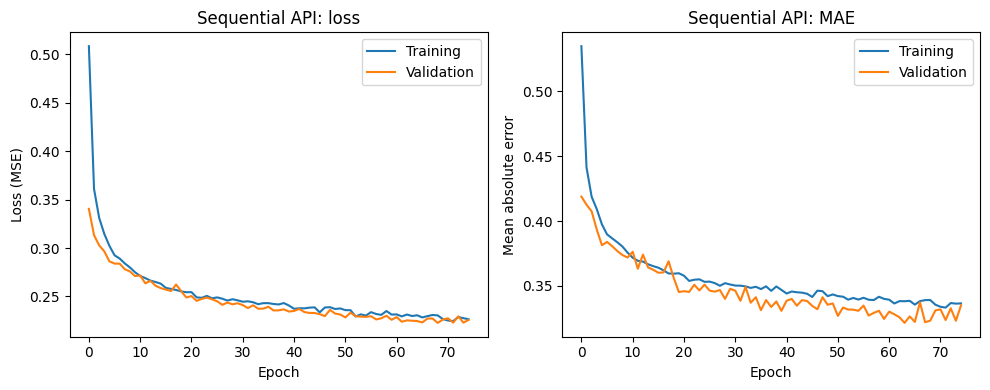

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Sequential API: loss')
axes[0].plot(sequential_history.history['loss'], label='Training')
axes[0].plot(sequential_history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend(loc='best')

axes[1].set_title('Sequential API: MAE')
axes[1].plot(sequential_history.history['mae'], label='Training')
axes[1].plot(sequential_history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean absolute error')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

### 3.4. Test set evaluation

In [14]:
sequential_predictions = sequential_model.predict(testing_df[features], verbose=0).flatten()

ss_res = np.sum((testing_df[label] - sequential_predictions) ** 2)
ss_tot = np.sum((testing_df[label] - np.mean(testing_df[label])) ** 2)
sequential_rsquared = 1 - (ss_res / ss_tot)

print(f'Sequential API model R² on test set: {sequential_rsquared:.4f}')

Sequential API model R² on test set: 0.7860


### 3.5. Performance analysis

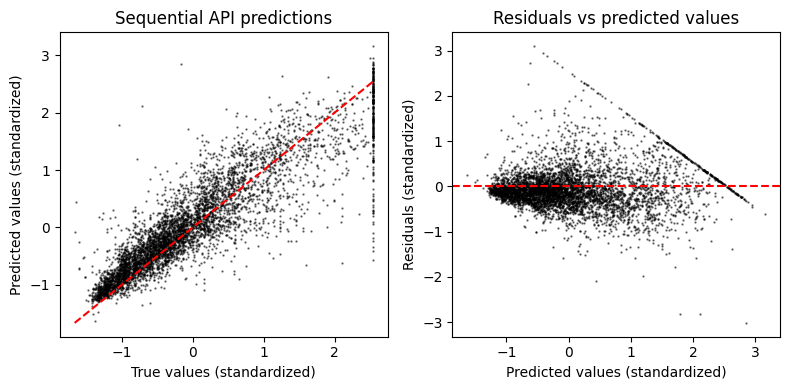

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Sequential API predictions')
axes[0].scatter(
    testing_df[label], sequential_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)
axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    sequential_predictions, testing_df[label] - sequential_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()

## 4. Keras Functional API model

The Functional API provides more flexibility than the Sequential API. It allows you to create models with non-linear topology, shared layers, and multiple inputs or outputs.

### 4.1. Build model

In [16]:
# Define input layer
inputs = keras.Input(shape=(8,), name='input_features')

# Define hidden layers
x = layers.Dense(64, activation='relu', name='hidden_1')(inputs)
x = layers.Dropout(0.2, name='dropout_1')(x)
x = layers.Dense(32, activation='relu', name='hidden_2')(x)
x = layers.Dropout(0.2, name='dropout_2')(x)

# Define output layer
outputs = layers.Dense(1, name='output')(x)

# Create model
functional_model = Model(inputs=inputs, outputs=outputs, name='functional_mlp')

functional_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss='mse',
    metrics=['mae']
)

functional_model.summary()

Model: "functional_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer  [(None, 8)]               0         
 )                                                               
                                                                 
 hidden_1 (Dense)            (None, 64)                576       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 hidden_2 (Dense)            (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 output (Dense)              (None, 1)                 33        
                                                    

### 4.2. Train model

In [17]:
functional_history = functional_model.fit(
    training_df[features],
    training_df[label],
    epochs=75,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

print('Training complete.')
print(f'Final training loss: {functional_history.history["loss"][-1]:.4f}')
print(f'Final validation loss: {functional_history.history["val_loss"][-1]:.4f}')

Epoch 1/75
774/774 [==============================] - 6s 6ms/step - loss: 0.4852 - mae: 0.5254 - val_loss: 0.3320 - val_mae: 0.4089
Epoch 2/75
774/774 [==============================] - 4s 5ms/step - loss: 0.3506 - mae: 0.4347 - val_loss: 0.3098 - val_mae: 0.4046
Epoch 3/75
774/774 [==============================] - 4s 5ms/step - loss: 0.3272 - mae: 0.4171 - val_loss: 0.2975 - val_mae: 0.3959
Epoch 4/75
774/774 [==============================] - 4s 5ms/step - loss: 0.3100 - mae: 0.4052 - val_loss: 0.2922 - val_mae: 0.3885
Epoch 5/75
774/774 [==============================] - 4s 5ms/step - loss: 0.3001 - mae: 0.3957 - val_loss: 0.2846 - val_mae: 0.3800
Epoch 6/75
774/774 [==============================] - 4s 5ms/step - loss: 0.2923 - mae: 0.3884 - val_loss: 0.2815 - val_mae: 0.3791
Epoch 7/75
774/774 [==============================] - 4s 5ms/step - loss: 0.2866 - mae: 0.3833 - val_loss: 0.2789 - val_mae: 0.3776
Epoch 8/75
774/774 [==============================] - 4s 5ms/step - loss: 0.

### 4.3. Learning curves

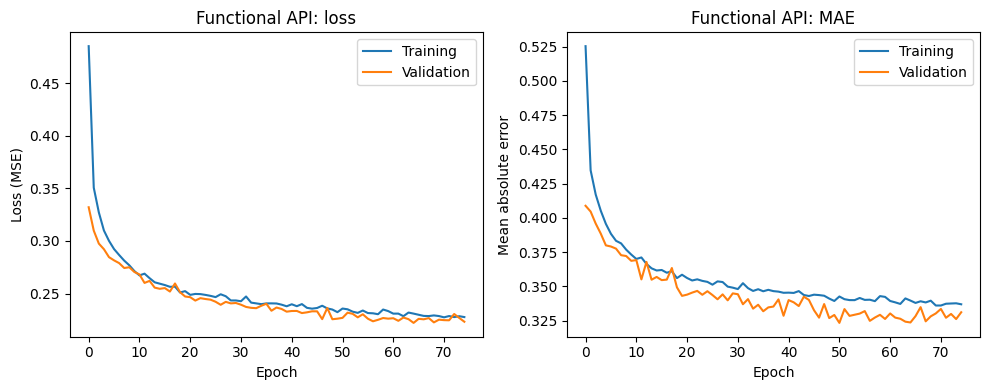

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Functional API: loss')
axes[0].plot(functional_history.history['loss'], label='Training')
axes[0].plot(functional_history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend(loc='best')

axes[1].set_title('Functional API: MAE')
axes[1].plot(functional_history.history['mae'], label='Training')
axes[1].plot(functional_history.history['val_mae'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean absolute error')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

### 4.4. Test set evaluation

In [19]:
functional_predictions = functional_model.predict(testing_df[features], verbose=0).flatten()

ss_res = np.sum((testing_df[label] - functional_predictions) ** 2)
ss_tot = np.sum((testing_df[label] - np.mean(testing_df[label])) ** 2)
functional_rsquared = 1 - (ss_res / ss_tot)

print(f'Functional API model R² on test set: {functional_rsquared:.4f}')

Functional API model R² on test set: 0.7852


### 4.5. Performance analysis

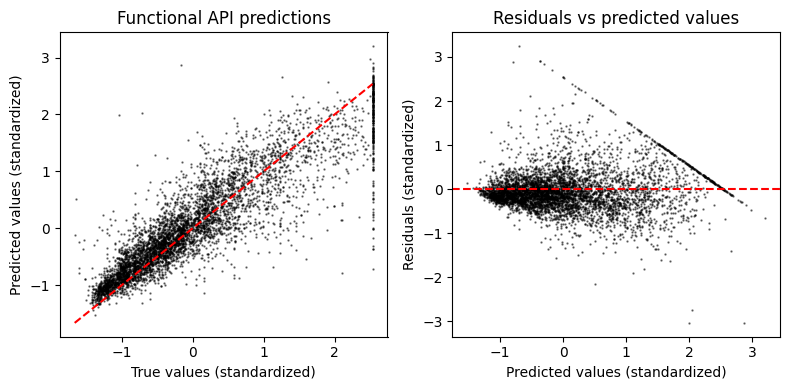

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Functional API predictions')
axes[0].scatter(
    testing_df[label], functional_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    functional_predictions, testing_df[label] - functional_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()

## 5. Model comparison

In [21]:
print(f'Linear regression R² on test set: {linear_rsquared:.4f}')
print(f'Sequential API model R² on test set: {sequential_rsquared:.4f}')
print(f'Functional API model R² on test set: {functional_rsquared:.4f}')

Linear regression R² on test set: 0.6586
Sequential API model R² on test set: 0.7860
Functional API model R² on test set: 0.7852


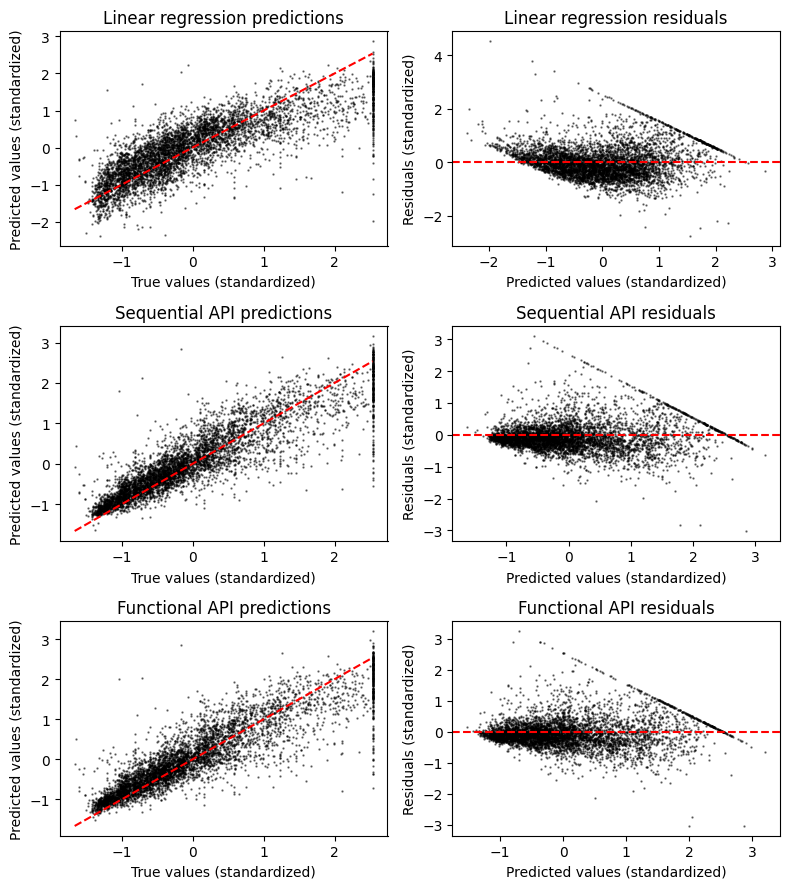

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(8, 9))

# Linear regression
axes[0, 0].set_title('Linear regression predictions')
axes[0, 0].scatter(
    testing_df[label], linear_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[0, 0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[0, 0].set_xlabel('True values (standardized)')
axes[0, 0].set_ylabel('Predicted values (standardized)')

axes[0, 1].set_title('Linear regression residuals')
axes[0, 1].scatter(
    linear_predictions, testing_df[label] - linear_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted values (standardized)')
axes[0, 1].set_ylabel('Residuals (standardized)')

# Sequential API
axes[1, 0].set_title('Sequential API predictions')
axes[1, 0].scatter(
    testing_df[label], sequential_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[1, 0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[1, 0].set_xlabel('True values (standardized)')
axes[1, 0].set_ylabel('Predicted values (standardized)')

axes[1, 1].set_title('Sequential API residuals')
axes[1, 1].scatter(
    sequential_predictions, testing_df[label] - sequential_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted values (standardized)')
axes[1, 1].set_ylabel('Residuals (standardized)')

# Functional API
axes[2, 0].set_title('Functional API predictions')
axes[2, 0].scatter(
    testing_df[label], functional_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[2, 0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)

axes[2, 0].set_xlabel('True values (standardized)')
axes[2, 0].set_ylabel('Predicted values (standardized)')

axes[2, 1].set_title('Functional API residuals')
axes[2, 1].scatter(
    functional_predictions, testing_df[label] - functional_predictions,
    c='black', s=0.5, alpha=0.5
)

axes[2, 1].axhline(0, color='red', linestyle='--')
axes[2, 1].set_xlabel('Predicted values (standardized)')
axes[2, 1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()